We assume water

The problem we are solving
where $p$ is the pressure field
\begin{gather}
    \begin{aligned}
        &- \nabla \cdot \dfrac{K}{\mu} \nabla p = f &\text{ in } \Omega\\
        &p = \overline{p} & \text{ on } \partial \Omega
    \end{aligned}
\end{gather}
the data in the previous equations are
* $K$ is the permeability of the rock/fracture, measured in $[m^2]$ or $[Darcy]$
* $\mu$ is the dynamic viscosity of the water, which is $3.1 \cdot 10^{-4} [Pa \cdot s]$
* $f$ is the source term, used to represents the wells
* $\overline{p}$ imposed pressure at the boundary, in the sequel assume to be hydrostatic

Define the geometry of the problem, we assume that the domain is a rectangle. 
Everything marked with a `[*]` can be modified by user needs.

In [1]:
import numpy as np
from porepy.params.units import *

#[*] path for the fracture network file name
fracture_file_name = 'network.csv'

#[*] folder to store the simulation results
folder_name = 'results'

#[*] activate to export solution in vtu format (for ParaView)
save_solution = True

# ------ general properties ------

#[*] depth of the problem, unit [m]
depth = 2 * (KILOMETER)

#[*] atmospheric pressure, unit [Pa] or [bar]
atmospheric_pressure = 1 * (BAR)

# gravity acceleration, unit [m/s^2]
gravity_acceleration = 9.81 * (METER/SECOND**2)

#[*] atmospheric temperature, unit [*C]
atmospheric_temperature = 20 * (CELSIUS)

# geothermal gradient, [*C/m]
geothermal_gradient = 25 * (CELSIUS/KILOMETER)

# ------ rock/fracture properties ------

#[*] define the fracture and rock matrix permeability, unit [m^2 or Darcy]
fracture_permeability = 1e3 * (MILLIDARCY)
rock_matrix_permeability = 1e-2 * (MILLIDARCY)

#[*] define the fracture aperture, unit [m]
fracture_aperture = 1 * (CENTIMETER)

# ------ water properties ------

#[*] define the water dynamic viscosity [Pa * s]
viscosity = 3.1*1e-4 * (PASCAL*SECOND)

#[*] define the water density 
density = 1e3 * (KILOGRAM/METER**3)

# ------ well properties ------

#[*] define the well positions, unit [m]
wells = (METER) * np.array([[ 150, 250],
                             [800, 300]])

#[*] define the well flow rate, unit [??]
wells_flow_rate = np.array([1, -1])

# ------discretization properties ------

#[*] domain bounding box, unit [m]
domain = {'xmin': 0 * (KILOMETER), 'xmax': 1 * (KILOMETER), 
          'ymin': 0 * (KILOMETER), 'ymax': 1 * (KILOMETER)}

#[*] define the mesh size of the problem
mesh_size = 400 * (METER)

#[*] end time for the simulation [s]
end_time = 10 * (YEAR)

#[*] number of time steps
number_time_steps = 1

# geometrical tolerance for the computations, unit [m]
tol = 1e-7 * (METER)

To plot the fracture network and the wells, it can be used to place correctly the wells.

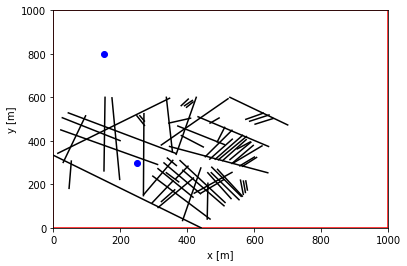

In [3]:
import matplotlib.pyplot as plt
from porepy.fracs import frac_viz_utils, importer

# import the fractures from the csv file
pts, edges = importer.lines_from_csv(fracture_file_name, tol=tol)

# plot the fractures and the wells in blue
frac_viz_utils.plot_fractures(domain, pts, edges, plot=False, fig_id=1)
plt.figure(1)
for well in wells.T:
    plt.plot(*well, 'o', color='blue')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')    
plt.show()

Run single-phase flow and transport models.

In [2]:
from darcy_and_transport_data import Simulation, create_grid

# create the computational grid
gb = create_grid(fracture_file_name, domain, mesh_size, tol)

# define the pressure boundary conditions as hydrostatic pressure
bc_pressure = density * gravity_acceleration * depth + atmospheric_pressure

# define the temperature boundary conditions with geothermal gradient
bc_temperature = geothermal_gradient * depth + atmospheric_temperature

# pack the problem data in a single dictionary
data_problem = {'domain': domain, 'tol': tol, 
                'bc_pressure': bc_pressure, 'bc_temperature': bc_temperature,
                'kf': fracture_permeability/viscosity, 'km': rock_matrix_permeability/viscosity,
                'aperture': fracture_aperture, 'wells': wells, 'wells_flow_rate': wells_flow_rate,
                'end_time': end_time, 'number_time_steps': number_time_steps,
                'folder_name': folder_name}

# run the simulation and save the solution
simulation = Simulation(gb, data_problem)
simulation.solve(save_as="temperature")

Gmsh processed file successfully


Grid creation completed. Elapsed time 0.4817638397216797


Created 1 2-d grids with 12552 cells
Created 63 1-d grids with 1309 cells
Created 85 0-d grids with 85 cells


[ nan  nan] [ inf  inf]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[25 18] [ 283891.71024925    7867.87225211]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[11  0] [ 92355.43410051  29960.15153835]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[6 0] [ 94677.54102454  37155.68684256]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[ 0 27] [ 92671.82345911    414.74679465]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[35  0] [ 76304.61300959  13565.77050091]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[43  0] [ 117527.77617662   15277.84529709]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[ 0 17] [ 45712.71965593   3309.49266077]
(2, 2)
[[ 150.  250.]
 [ 800.  300.]
 [   0.    0.]]
[ 0 16] [ 44321.59574051   9690.1499521 ]
(2, 2)
[[

[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ inf  inf]
[ nan  nan] [ in

Solve elliptic model
Discretize
Done. Elapsed time 4.857301712036133
Solve linear system using direct solver
Done. Elapsed time 0.06343579292297363
Time stepping using 1 steps
Step 0 out of 1


In [4]:
bc_temperature
bc_pressure

19721325.0

Compute production altre cose? outflow

In [6]:
from darcy_and_transport_data import compute_outflow

outflow = compute_outflow(gb)
print("Outflow ", outflow)

Outflow  1.81263113789e-07
